# Tutorial 7: expanding data dimension in recordwriter and pipeline

In many domains (especially medical imaging), multiple examples are sampled from the same data, we call it data dimension expansion. In this tutorial we will show you how to do data dimension expansion in FastEstimator.

In general, expanding data dimension can be achieved in both `RecordWriter` and `Pipeline`. Here are the differences:

* Expanding data in `RecordWriter` means occupying more disk-space, and the expanded samples are fixed during the training. The good thing is that it saves preprocessing computation during training.

* Expanding data in `Pipeline` means expanded data can be different for every batch during training, the computation is done in-memory therefore no extra disk space is required. The drawback is additional computation is required.

## RecordWriter: expanding dimension and write to disk

In recordwriter, for each 28x28 image, let's create 4 different 27x27 images from corners:

In [ ]:
from fastestimator.dataset.mnist import load_data
from fastestimator.util.op import NumpyOp
from fastestimator.record.preprocess import ImageReader
import fastestimator as fe
import numpy as np
import os

train_csv, eval_csv, data_path = load_data()

class SampleCorner(NumpyOp):
    def forward(self, data, state):
        x, y = data
        x = np.array([x[:27, :27, :],
                      x[1:, 1:, :],
                      x[:27, 1:, :],
                      x[1:, :27, :]])
        y = np.array([y, y, y, y])
        return x, y

writer = fe.RecordWriter(save_dir=os.path.join(data_path, "FEdata_replicate"),
                         train_data=train_csv,
                         validation_data=eval_csv,
                         ops=[ImageReader(inputs="x", outputs="x", parent_path=data_path, grey_scale=True),
                              SampleCorner(inputs=("x", "y"), outputs=("x", "y"))],
                         expand_dims=True)

## Pipeline: expanding dimension on the fly

In the last step, we extracted 4 different 27x27 sub-images for each image. Now for each 27x27 image, let's randomly sub-sample two 20x20 images during the training:

In [2]:
from fastestimator.pipeline.processing import Minmax
from fastestimator.util.op import TensorOp
import tensorflow as tf

class RandomSample(TensorOp):
    def forward(self, data, state):
        x, y = data
        x1_top_left = tf.random.uniform([], maxval=8, dtype=tf.int32)
        y1_top_left = tf.random.uniform([], maxval=8, dtype=tf.int32)
        x2_top_left = tf.random.uniform([], maxval=8, dtype=tf.int32)
        y2_top_left = tf.random.uniform([], maxval=8, dtype=tf.int32)
        x = tf.stack([x[x1_top_left:x1_top_left+20, y1_top_left:y1_top_left+20, :], 
                      x[x2_top_left:x2_top_left+20, y2_top_left:y2_top_left+20, :]])
        y = tf.stack([y, y])
        return x, y

pipeline = fe.Pipeline(data=writer,
                       batch_size=32,
                       ops=[Minmax(inputs="x", outputs="x"),
                            RandomSample(inputs=("x", "y"), outputs=("x", "y"))],
                       expand_dims=True)

## access the pipeline results

In [3]:
result = pipeline.show_results()
x = result[0]["x"]
y = result[0]["y"]
print("shape of feature x is {}".format(x.shape))
print("shape of feature y is {}".format(y.shape))

FastEstimator: Reading non-empty directory: /var/folders/5g/d_ny7h211cj3zqkzrtq01s480000gn/T/.fe/Mnist/FEdata_replicate
FastEstimator: Found 240000 examples for train in /var/folders/5g/d_ny7h211cj3zqkzrtq01s480000gn/T/.fe/Mnist/FEdata_replicate/train_summary0.json
FastEstimator: Found 40000 examples for eval in /var/folders/5g/d_ny7h211cj3zqkzrtq01s480000gn/T/.fe/Mnist/FEdata_replicate/eval_summary0.json
shape of feature x is (32, 20, 20, 1)
shape of feature y is (32,)


## visualize

ground truth label is 9
ground truth label is 9
ground truth label is 7
ground truth label is 7


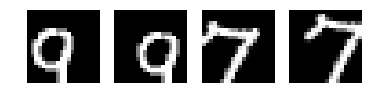

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4)
for i in range(4):
    axes[i].axis('off')
    axes[i].imshow(np.squeeze(x[i]), cmap='gray')
    print("ground truth label is {}".format(y[i]))

As we can see, each image is indeed generating two random patches.